In [1]:
import json
import torch
import pandas as pd
import numpy as np
from collections import Counter
from torch_geometric import nn as geo_nn
from sklearn.metrics import roc_auc_score
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch.nn import functional as F
from torch_scatter import scatter_mean

In [13]:
features_friends = pd.read_csv("data/FINAL_FEATURES_FRIENDS.tsv", sep='\t')
all_seq_traintest = pd.read_csv("data/FINAL_ALL_SEQUENCES_TRAINTEST.tsv", sep='\t')
features_traintest = pd.read_csv("data/FINAL_FEATURES_TRAINTEST.tsv", sep='\t')
target_traintest = pd.read_csv("data/FINAL_TARGETS_DATES_TRAINTEST.tsv", sep='\t')
seq_matrix = pd.read_csv("data/FINAL_SEQUENCES_MATRIX.csv", sep='\t')

In [9]:
data.drop(["Unnamed: 0"], inplace=True, axis=1)
data.to_csv("data/friends_user_embeddings.csv", index=False)

In [33]:
target_traintest = pd.read_csv("data/FINAL_TARGETS_DATES_TRAINTEST.tsv", sep='\t')

test_ids  = target_traintest[target_traintest["TARGET"] == "test"]["CLIENT_ID"].values
train_ids = target_traintest[target_traintest["TARGET"] != "test"]["CLIENT_ID"].values

In [34]:
features_traintest = pd.read_csv("data/FINAL_FEATURES_TRAINTEST.tsv", sep='\t')

train_target_features = pd.merge(target_traintest[target_traintest["TARGET"] != "test"], features_traintest, 
                                 left_on="CLIENT_ID", right_on="CLIENT_ID")
train_target_features.fillna(0, inplace=True)
train_target_features["TARGET"] = train_target_features["TARGET"].astype(int)
train_target_features.head()

,CLIENT_ID,RETRO_DT,TARGET,i1047,i1048,i1056,i1058,i1059,i1060,i1065,...,u8=17,u8=18,u8=19,u8=2,u8=20,u8=21,u8=6,u8=7,u8=8,u8=9
0,1011725,20210501,0,0.0,0.0,304.0,0.0,0.0,28.0,165.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1018784,20210501,1,0.0,3.0,157.0,0.0,0.0,0.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1021812,20210501,0,0.0,250.0,314.0,3.0,12.0,525.0,107.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1024003,20210501,0,0.0,4.0,17.0,0.0,3.0,3.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1026390,20210501,1,0.0,0.0,255.0,0.0,17.0,0.0,168.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## GAT

In [28]:
from torch_geometric.data import Data
from torch_geometric.transforms import ToUndirected

to_und = ToUndirected()

def make_data(x):
    fr_feat = features_friends[features_friends["CLIENT_ID"] == x["CLIENT_ID"]]
    num_friends = fr_feat.shape[0]
    edge_index = np.hstack([np.arange(1, num_friends + 1)[:, None], np.zeros(shape=[num_friends, 1], dtype=np.int64)])
    y = x["TARGET"]
    res = Data(x=torch.from_numpy(np.concatenate([np.array(x.drop(["CLIENT_ID", "RETRO_DT", "TARGET"]))[None, :], 
                                                    np.array(fr_feat.drop(["CLIENT_ID", "FRIEND_ID"], axis=1))])), 
               edge_index=torch.from_numpy(edge_index).T,
               y=y,
               client_id = x["CLIENT_ID"])
    res = to_und(res)
    return res

friends_dataset = train_target_features.apply(lambda x: make_data(x), axis=1)
friends_dataset.sample(10)

61221    [(x, [tensor([0., 0., 0.,  ..., 0., 0., 0.], d...
33134    [(x, [tensor([  0.,   4., 467.,  ...,   0.,   ...
54375    [(x, [tensor([  0.,   1., 720.,  ...,   0.,   ...
53613    [(x, [tensor([   0.,    0., 1217.,  ...,    0....
50411    [(x, [tensor([ 0.,  0., 15.,  ...,  0.,  0.,  ...
78383    [(x, [tensor([0., 0., 0.,  ..., 0., 0., 0.], d...
14471    [(x, [tensor([  0.,   0., 580.,  ...,   0.,   ...
27327    [(x, [tensor([ 0.,  0., 17.,  ...,  0.,  0.,  ...
52440    [(x, [tensor([ 0.,  1., 56.,  ...,  0.,  0.,  ...
2189     [(x, [tensor([0., 0., 3.,  ..., 0., 0., 0.], d...
dtype: object

In [30]:
mask = np.random.choice(friends_dataset.shape[0], size=friends_dataset.shape[0], replace=False)
ratio = int(0.8 * len(mask))
train_dataset, val_dataset = friends_dataset[mask[:ratio]].values, friends_dataset[mask[ratio:]].values

In [32]:
torch.save(train_dataset, "data/processed/train_dataset.pt")
torch.save(val_dataset, "data/processed/val_dataset.pt")
#torch.save(test_dataset, "data/processed/test_dataset.pt")

In [67]:
from torch_geometric.loader import DataLoader

dataloaders = {"train": DataLoader(train_dataset, batch_size=10_000),
               "val": DataLoader(val_dataset, batch_size=1000)}

In [73]:
class NodeEncoder(Module):
    def __init__(self, in_features, hid_features, out_features):
        super().__init__()
        self.linear_in = Linear(in_features, in_features)
        self.gat = GATv2Conv(in_channels=in_features, 
                       hidden_channels=hid_features, 
                       out_channels=hid_features,
                       num_layers=1)
        self.linear_out = Linear(hid_features, out_features)
        
    def forward(self, data):
        x, edges = data.x, data.edge_index
        x = self.gat(relu(self.linear_in(x.float())), edges, )
        x = self.linear_out(relu(x))
        return softmax(scatter_mean(x, data.batch, dim=0), dim=1)

node_encoder = NodeEncoder(features_traintest.shape[1]-1, 512, 2)

In [74]:
for i in dataloaders["train"]:
    res = node_encoder(i)
    print(res.shape)
    break

torch.Size([10000, 2])


In [75]:
i.y.int()

tensor([0, 1, 1,  ..., 0, 0, 1], dtype=torch.int32)

In [76]:
res

tensor([[1.0000e+00, 9.6783e-23],
        [0.0000e+00, 1.0000e+00],
        [0.0000e+00, 1.0000e+00],
        ...,
        [0.0000e+00, 1.0000e+00],
        [5.0094e-01, 4.9906e-01],
        [6.7523e-29, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)

In [72]:
class_weights = target_traintest[target_traintest["TARGET"] != "test"]["TARGET"].values.astype(int).mean()
class_weights = torch.FloatTensor([class_weights, 1-class_weights])
class_weights

tensor([0.2742, 0.7258])

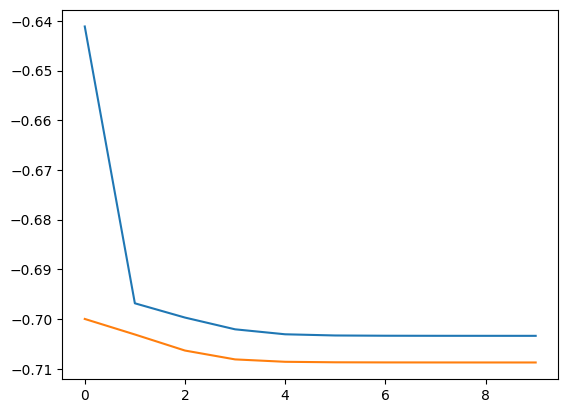

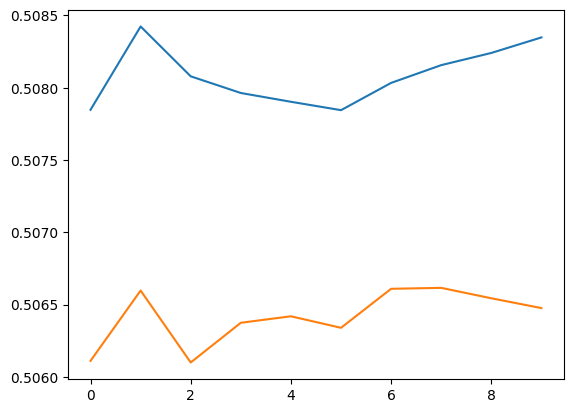

KeyboardInterrupt: 

In [77]:
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from IPython.display import clear_output
import matplotlib.pyplot as plt


def train(model, dataloaders, epochs=100, class_weights=None, verbose=False, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = torch.nn.NLLLoss(weight=class_weights)
    
    auc_history  = defaultdict(list)
    loss_history = defaultdict(list)
    for ep in range(epochs):
        roc_aucs = []
        losses = []
        model.train()
        for data in dataloaders["train"]:
            optimizer.zero_grad()
            out = model(data)
            l = loss(out, data.y.long())
            losses.append(l.item())
            l.backward()
            optimizer.step()
            roc_aucs.append(roc_auc_score(data.y, out[:, 1].detach()))
        auc_history["train"].append(np.mean(roc_aucs))
        loss_history["train"].append(np.mean(losses))
        
        roc_aucs = []
        losses = []
        model.eval()
        for data in dataloaders["val"]:
            out = model(data)
            l = loss(out, data.y.long())
            losses.append(l.item())
            roc_aucs.append(roc_auc_score(data.y, out[:, 1].detach()))
        auc_history["val"].append(np.mean(roc_aucs))
        loss_history["val"].append(np.mean(losses))
        
        clear_output(wait=True)
        
        plt.plot(range(len(loss_history["train"])), loss_history["train"], label="train")
        plt.plot(range(len(loss_history["val"])), loss_history["val"], label="val")
        plt.show()
        
        plt.plot(range(len(auc_history["train"])), auc_history["train"], label="train")
        plt.plot(range(len(auc_history["val"])), auc_history["val"], label="val")
        plt.show()
    return score
score = train(node_encoder, dataloaders)

## Пробуем просто линейный + конкатенация

In [4]:
target_traintest = pd.read_csv("data/FINAL_TARGETS_DATES_TRAINTEST.tsv", sep='\t')

#test_ids  = target_traintest[target_traintest["TARGET"] == "test"]["CLIENT_ID"].values
#train_ids = target_traintest[target_traintest["TARGET"] != "test"]["CLIENT_ID"].values
features_traintest = pd.read_csv("data/FINAL_FEATURES_TRAINTEST.tsv", sep='\t')

#target_features = pd.merge(target_traintest, features_traintest, 
#                                 left_on="CLIENT_ID", right_on="CLIENT_ID")
target_features.fillna(0, inplace=True)
test_target_features = target_features[target_features["TARGET"] == "test"].drop(["TARGET"], axis=1)
train_target_features = target_features[target_features["TARGET"] != "test"]
train_target_features["TARGET"] = train_target_features["TARGET"].astype(int)
test_target_features.head()

/tmp/ipykernel_1070/3706286511.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_target_features["TARGET"] = train_target_features["TARGET"].astype(int)


,CLIENT_ID,RETRO_DT,i1047,i1048,i1056,i1058,i1059,i1060,i1065,i1066,...,u8=17,u8=18,u8=19,u8=2,u8=20,u8=21,u8=6,u8=7,u8=8,u8=9
4,1025140,20210501,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1029732,20210501,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,1079794,20210501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,1116331,20210501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,1136822,20210501,0.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
features_traintest = pd.read_csv("data/FINAL_FEATURES_TRAINTEST.tsv", sep='\t')
features_friends = pd.read_csv("data/FINAL_FEATURES_FRIENDS.tsv", sep='\t')

In [3]:
def make_data(x):
    friends = features_friends[features_friends["CLIENT_ID"] == x["CLIENT_ID"]]
    friend_embedding = friends.mean(axis=0)
    usr_features = pd.merge(x.to_frame().T, friend_embedding.to_frame().T, how="left",
                            left_on="CLIENT_ID", right_on="CLIENT_ID")
    return usr_features.drop(["FRIEND_ID"], axis=1).reset_index(drop=True)

friends_dataset = features_traintest.apply(lambda x: make_data(x), axis=1)
#features_friends.groupby(["CLIENT_ID"]).apply(lambda x: make_data(x))
print("ы")
friends_dataset.to_csv("data/user_friends_embeddings.csv")
#friends_dataset = features_traintest.apply(lambda x: make_data(x), axis=1)
#test_friends_dataset = test_target_features.apply(lambda x: make_data(x), axis=1)
#targets = train_target_features["TARGET"].values

#friends_dataset[0].shape
#friends_dataset.to_csv("data/)

ы


In [6]:
friends = pd.concat(friends_dataset.values)

In [8]:
friends.to_csv("data/user_friends_embeddings.csv")

In [101]:
class FriendsEmbedder(torch.nn.Module):
    def __init__(self, in_features, hid_features, out_features):
        super().__init__()
        self.linear_in = nn.Linear(in_features, hid_features)
        self.linear_out = nn.Linear(hid_features, out_features)
    
    def forward(self, x):
        x_hid = F.relu(self.linear_in(x))
        x_out = self.linear_out(x_hid)
        return F.softmax(x_out, dim=1)
friend_embedder = FriendsEmbedder(friends_dataset[0].shape[0], 512, 2)

In [102]:
mask = np.random.choice(friends_dataset.shape[0], size=friends_dataset.shape[0], replace=False)
ratio = int(0.8 * len(mask))
X_train, X_val = np.vstack(friends_dataset[mask[:ratio]].values), np.vstack(friends_dataset[mask[ratio:]].values)
y_train, y_val = targets[mask[:ratio]], targets[mask[ratio:]]

In [103]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_val = torch.from_numpy(X_val.astype(np.float32))
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)

In [104]:
class_weights = target_traintest[target_traintest["TARGET"] != "test"]["TARGET"].values.astype(int).mean()
class_weights = torch.FloatTensor([class_weights, 1-class_weights])
class_weights

tensor([0.2742, 0.7258])

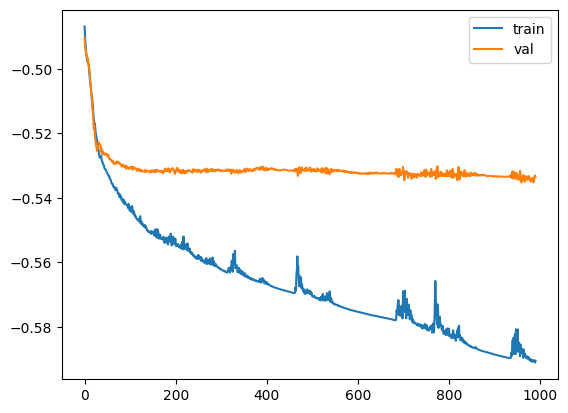

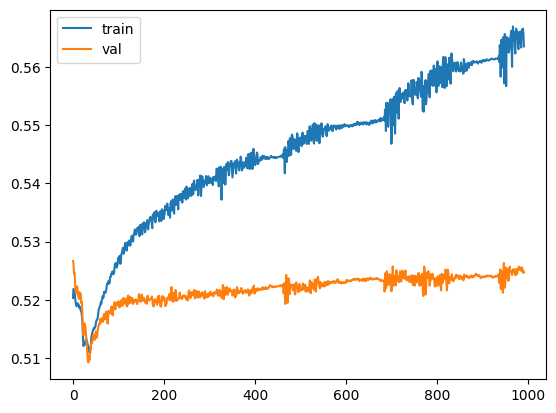

In [105]:
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from IPython.display import clear_output
import matplotlib.pyplot as plt

def predict(model, X, y, loss):
    out = model(X)
    l = loss(out, y)
    return l, roc_auc_score(y, out[:, 1].detach())

def train(model, X_train, y_train, X_val, y_val, epochs=100, class_weights=None, verbose=False, lr=3e-5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = torch.nn.NLLLoss(weight=class_weights)
    
    auc_history  = defaultdict(list)
    loss_history = defaultdict(list)
    for ep in range(epochs):
        model.train()
        optimizer.zero_grad()
        l, auc = predict(model, X_train, y_train, loss)
        loss_history["train"].append(l.item())
        auc_history["train"].append(auc)
        l.backward()
        optimizer.step()
        
        model.eval()
        l, auc = predict(model, X_val, y_val, loss)
        loss_history["val"].append(l.item())
        auc_history["val"].append(auc)
        
        if ep % 10 == 0:
            clear_output(wait=True)
            plt.plot(range(len(loss_history["train"])), loss_history["train"], label="train")
            plt.plot(range(len(loss_history["val"])), loss_history["val"], label="val")
            plt.legend()
            plt.show()

            plt.plot(range(len(auc_history["train"])), auc_history["train"], label="train")
            plt.plot(range(len(auc_history["val"])), auc_history["val"], label="val")
            plt.legend()
            plt.show()
train(friend_embedder, X_train, y_train, X_val, y_val, 
      class_weights=class_weights, epochs=1000)

In [106]:
friend_embedder(X_val).mean(axis=0), y_val.float().mean()

(tensor([0.2898, 0.7102], grad_fn=<MeanBackward1>), tensor(0.2951))

In [ ]:
features_friends = pd.read_csv("data/FINAL_FEATURES_FRIENDS.tsv", sep='\t')
all_seq_traintest = pd.read_csv("data/FINAL_ALL_SEQUENCES_TRAINTEST.tsv", sep='\t')
features_traintest = pd.read_csv("data/FINAL_FEATURES_TRAINTEST.tsv", sep='\t')
target_traintest = pd.read_csv("data/FINAL_TARGETS_DATES_TRAINTEST.tsv", sep='\t')
seq_matrix = pd.read_csv("data/FINAL_SEQUENCES_MATRIX.csv", sep='\t')

## Word2Vec

In [2]:
from gensim.models import Word2Vec

In [12]:
def get_sentences(name, column):
    sentences = pd.read_csv(name, sep='\t')
    sentences = sentences[column].apply(lambda x: json.loads(x.replace("'", '"')))
    return sentences

sentences_mat = get_sentences("data/FINAL_SEQUENCES_MATRIX.csv", "SESSIONS_SEQUENCES")
sentences_all = get_sentences("data/FINAL_ALL_SEQUENCES_TRAINTEST.tsv", "SEQUENCE")
sentences = np.concatenate([sentences_mat, sentences_all])
sentences.shape[0] == sentences_mat.shape[0] + sentences_all.shape[0]

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [21]:
model = Word2Vec(sentences=sentences, vector_size=200, window=5, min_count=1, workers=4)
model.save("data/word2vec.model")

In [4]:
model = Word2Vec.load("data/word2vec.model")
#model.train(sentences, total_examples=sentences.shape[0], epochs=5)

In [22]:
for word in json.loads(all_seq_traintest.loc[0]["SEQUENCE"].replace("'", '"')):
    print(model.wv[word].shape)

(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)


In [44]:
from torch_geometric.data import Data

def collect_graph(row):
    sequence = json.loads(row['SEQUENCE'].replace("'", '"'))
    if len(sequence) > 1:
        x = torch.from_numpy(np.vstack([model.wv[word] for word in sequence]))
        nodes = list(set(sequence))
        edge_index = torch.LongTensor([[nodes.index(sequence[i]), 
                                        nodes.index(sequence[i+1])] for i in range(len(nodes)-1)]).T
    elif len(sequence) == 1:
        x = torch.from_numpy(np.array(model.wv[sequence[0]])[None, :])
        edge_index = torch.LongTensor()
    else:
        x = torch.FloatTensor()
        edge_index = torch.LongTensor()
    return Data(x=x, edge_index=edge_index, y=torch.LongTensor([int(row["TARGET"])]))

target_traintest = pd.read_csv("data/FINAL_TARGETS_DATES_TRAINTEST.tsv", sep='\t')
# test_ids  = target_traintest[target_traintest["TARGET"] == "test"].index
train_ids = target_traintest[target_traintest["TARGET"] != "test"].index
all_seq_traintest = pd.read_csv("data/FINAL_ALL_SEQUENCES_TRAINTEST.tsv", sep='\t')

targeted_sequences = pd.merge(target_traintest.iloc[train_ids], all_seq_traintest, on="CLIENT_ID")
targeted_sequences.fillna(0, inplace=True)
graph_sequences = targeted_sequences.apply(lambda x: collect_graph(x), axis=1)
#graph_sequences["CLIENT_ID"] = targeted_sequences["CLIENT_ID"]
#graph_sequences["TARGET"] = targeted_sequences["TARGET"]
graph_sequences

0        [(x, [tensor([ 0.1860,  1.3867, -1.5953,  1.70...
1        [(x, [tensor([-0.0156,  1.1201,  0.8188,  0.59...
2        [(x, [tensor([-3.6969e-02,  7.6490e-01,  2.171...
3        [(x, [tensor([-5.8542e-02,  1.6408e+00, -1.011...
4        [(x, [tensor([ 0.1315,  0.3126,  0.7061, -0.51...
                               ...                        
98938    [(x, [tensor([ 0.5836, -0.1100,  1.1718,  0.11...
98939    [(x, [tensor([ 3.2160e-01, -4.5308e-01, -3.363...
98940    [(x, [tensor([ 2.1938e+00,  1.8171e+00, -3.633...
98941    [(x, [tensor([-0.7559,  0.6764,  0.5907, -0.55...
98942    [(x, [tensor([ 1.6228,  0.0836,  0.1474,  0.42...
Length: 98943, dtype: object

In [ ]:
graph_sequences[1].y

In [51]:
class GraphCollector(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(200, 128)
        self.gcn1 = geo_nn.GCNConv(128, 128)
        self.linear2 = nn.Linear(128, 64)
        self.gcn2 = geo_nn.GCNConv(64, 64)
        self.linear3 = nn.Linear(64, 32)
        self.gcn3 = geo_nn.GCNConv(32, 32)
        self.linear4 = nn.Linear(32, 2)
        
    def forward(self, x, edge_index, batch=None):
        x = self.gcn1(F.relu(self.linear1(x)), edge_index)
        x = self.gcn2(F.relu(self.linear2(x)), edge_index)
        x = self.gcn3(F.relu(self.linear3(x)), edge_index)
        x = self.linear4(x)
        return F.softmax(scatter_mean(x, batch, dim=0), dim=1)

gnn = GraphCollector()

In [52]:
from torch_geometric.loader import DataLoader
mask = np.random.choice(graph_sequences.shape[0], size=graph_sequences.shape[0], replace=False)
ratio = int(0.8 * len(mask))
dataloaders = {"train": DataLoader(graph_sequences[mask[:ratio]].values, batch_size=10_000),
                "val": DataLoader(graph_sequences[mask[ratio:]].values, batch_size=10_000)}
#X_train, X_val = np.vstack(new_df[mask[:ratio]].values), np.vstack(new_df[mask[ratio:]].values)
#y_train, y_val = targets[mask[:ratio]], targets[mask[ratio:]]

In [55]:
dataset_cnt = 0
for i in dataloaders["train"]:
    print(np.unique(i.batch))
    out = gnn(i.x, i.edge_index, i.batch)
    print(i, out.shape, i.y.shape)
    break

[   0    1    2 ... 9997 9998 9999]
DataBatch(x=[1427638, 200], edge_index=[2, 282678], y=[10000, 1], batch=[1427638], ptr=[10001]) torch.Size([10000, 2]) torch.Size([10000, 1])


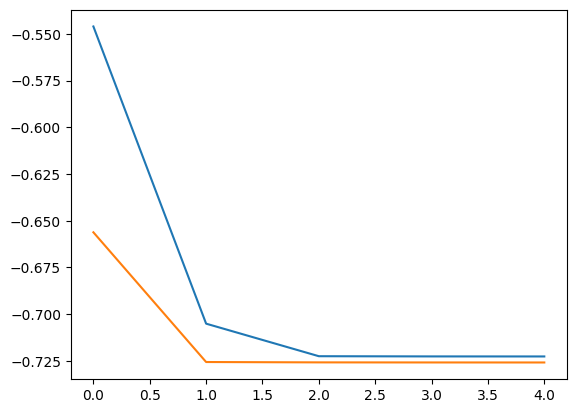

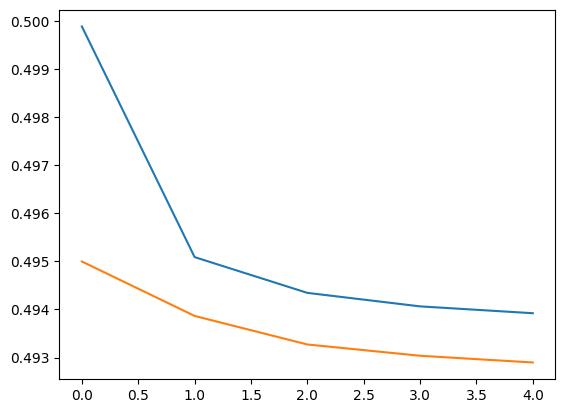

torch.Size([10000, 2]) torch.Size([10000, 1])
torch.Size([10000, 2]) torch.Size([10000, 1])
torch.Size([10000, 2]) torch.Size([10000, 1])


KeyboardInterrupt: 

In [56]:
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from IPython.display import clear_output
import matplotlib.pyplot as plt

def predict(model, X, y, loss):
    out = model(X)
    l = loss(out, y)
    return l, roc_auc_score(y, out[:, 1].detach())

def train(model, dataloaders, epochs=100, class_weights=None, verbose=False, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = torch.nn.NLLLoss(weight=class_weights)
    
    auc_history  = defaultdict(list)
    loss_history = defaultdict(list)
    for ep in range(epochs):
        roc_aucs = []
        losses = []
        model.train()
        for data in dataloaders["train"]:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            print(out.shape, data.y.shape)
            l = loss(out, data.y[:, 0])
            losses.append(l.item())
            l.backward()
            optimizer.step()
            roc_aucs.append(roc_auc_score(data.y, out[:, 1].detach()))
        auc_history["train"].append(np.mean(roc_aucs))
        loss_history["train"].append(np.mean(losses))
        
        roc_aucs = []
        losses = []
        model.eval()
        for data in dataloaders["val"]:
            out = model(data.x, data.edge_index, data.batch)
            l = loss(out, data.y[:, 0])
            losses.append(l.item())
            roc_aucs.append(roc_auc_score(data.y, out[:, 1].detach()))
        auc_history["val"].append(np.mean(roc_aucs))
        loss_history["val"].append(np.mean(losses))
        
        clear_output(wait=True)
        
        plt.plot(range(len(loss_history["train"])), loss_history["train"], label="train")
        plt.plot(range(len(loss_history["val"])), loss_history["val"], label="val")
        plt.show()
        
        plt.plot(range(len(auc_history["train"])), auc_history["train"], label="train")
        plt.plot(range(len(auc_history["val"])), auc_history["val"], label="val")
        plt.show()
    return score
score = train(gnn, dataloaders)

## Сумма эмбеддингов -> ctb

In [13]:
def collect_graph(row):
    if row['SEQUENCE'] == 0:
        return np.zeros(200)
    sequence = json.loads(row['SEQUENCE'].replace("'", '"'))
    if len(sequence) >= 1:
        return np.mean([model.wv[word] for word in sequence], axis=0)
    else:
        return np.zeros(200)

target_traintest = pd.read_csv("data/FINAL_TARGETS_DATES_TRAINTEST.tsv", sep='\t')
# test_ids  = target_traintest[target_traintest["TARGET"] == "test"].index
#train_ids = target_traintest[target_traintest["TARGET"] != "test"].index
all_seq_traintest = pd.read_csv("data/FINAL_ALL_SEQUENCES_TRAINTEST.tsv", sep='\t')

targeted_sequences = pd.merge(target_traintest, all_seq_traintest, on="CLIENT_ID", how='left')
targeted_sequences.fillna(0, inplace=True)
graph_sequences = np.vstack(targeted_sequences.apply(lambda x: collect_graph(x), axis=1))
#graph_sequences["CLIENT_ID"] = targeted_sequences["CLIENT_ID"]
#graph_sequences["TARGET"] = targeted_sequences["TARGET"]
graph_sequences.shape

KeyboardInterrupt: 

In [ ]:
target

In [21]:
graph_sequences.dtype

dtype('float64')

In [34]:
meanval = y_train.mean()
class_weights = [meanval, 1 - meanval]
class_weights

[0.2741932952476615, 0.7258067047523384]

In [26]:
np.save("data/graph_sequences.npy", graph_sequences)

In [35]:
graphs = np.load("data/graph_sequences.npy")
graphs.shape

(159290, 200)

In [47]:
X_train = graphs[target_traintest["TARGET"] != "test"]
X_test  = graphs[target_traintest["TARGET"] == "test"]
y_train = target_traintest[target_traintest["TARGET"] != "test"]["TARGET"].apply(int).values

In [37]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

mask = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=False)
ratio = int(0.8 * len(mask))
#targets = targeted_sequences["TARGET"].values

ctb_graph = CatBoostClassifier(iterations=1400, depth=5, learning_rate=1e-3, class_weights=class_weights)
ctb_graph.fit(X_train[mask[:ratio]], y_train[mask[:ratio]], verbose=False)

ctb_graph.save_model("shredder67/catboosts/ctb_graph.ctb")

In [49]:
ctb_graph = CatBoostClassifier(iterations=1400, depth=5, learning_rate=1e-3, class_weights=class_weights)
ctb_graph.fit(X_train, y_train, verbose=False)

ctb_graph.save_model("shredder67/catboosts/ctb_graph_full.ctb")

In [38]:
preds = ctb_graph.predict_proba(X_train[mask[ratio:]])
roc_auc_score(y_train[mask[ratio:]], preds[:, 1])

0.5657667437769949

In [18]:
ctb_graph.save_model("shredder67/catboosts/ctb_graph.ctb")

In [14]:
np.random.seed(42)

In [39]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
friends_users = pd.read_csv("data/user_friends_embeddings.csv")
friends_users = friends_users.drop(["Unnamed: 0"], axis=1)

In [40]:
target_traintest = pd.read_csv("data/FINAL_TARGETS_DATES_TRAINTEST.tsv", sep='\t')
friends_users_target = pd.merge(target_traintest, friends_users, on="CLIENT_ID", how="left")
friends_users_target

,CLIENT_ID,RETRO_DT,TARGET,i1047_x,i1048_x,i1056_x,i1058_x,i1059_x,i1060_x,i1065_x,...,u8=17_y,u8=18_y,u8=19_y,u8=2_y,u8=20_y,u8=21_y,u8=6_y,u8=7_y,u8=8_y,u8=9_y
0,1011725,20210501,0,0.0,0.0,304.0,0.0,0.0,28.0,165.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1018784,20210501,1,0.0,3.0,157.0,0.0,0.0,0.0,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1021812,20210501,0,0.0,250.0,314.0,3.0,12.0,525.0,107.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1024003,20210501,0,0.0,4.0,17.0,0.0,3.0,3.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1025140,20210501,test,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159285,72633,20210731,0,0.0,0.0,24.0,0.0,0.0,0.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159286,72634,20210731,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159287,72641,20210731,0,0.0,1.0,20.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159288,72642,20210731,test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
train = friends_users_target[friends_users_target["TARGET"] != "test"]
test  = friends_users_target[friends_users_target["TARGET"] == "test"]
X_train, X_test = train.drop(["TARGET"], axis=1), test.drop(["TARGET"], axis=1)
y_train = train["TARGET"].apply(int)

In [43]:
np.random.seed(42)

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

mask = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=False)
ratio = int(0.8 * len(mask))

X_train, X_val = X_train.iloc[mask[:ratio]], X_train.iloc[mask[ratio:]]
y_train, y_val = y_train.iloc[mask[:ratio]], y_train.iloc[mask[ratio:]]

In [45]:
ctb_friend_features = CatBoostClassifier(iterations=1400, depth=5, 
                                         learning_rate=1e-3, class_weights=class_weights)
ctb_friend_features.fit(X_train, y_train, verbose=False)

preds = ctb_friend_features.predict_proba(X_val)
roc_auc_score(y_val, preds[:, 1])

0.5951540482566186

In [52]:
ctb_friend_features = CatBoostClassifier(iterations=1400, depth=5, 
                                         learning_rate=1e-3, class_weights=class_weights)
ctb_friend_features.fit(train.drop('TARGET', axis=1), y_train, verbose=False, plot=True)

ctb_friend_features.save_model("shredder67/catboosts/ctb_friend_features_full.ctb")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [46]:
ctb_friend_features.save_model("shredder67/catboosts/ctb_friend_features.ctb")

In [21]:
target_traintest[target_traintest["TARGET"] == 'test']

,CLIENT_ID,RETRO_DT,TARGET
4,1025140,20210501,test
8,1029732,20210501,test
18,1079794,20210501,test
23,1116331,20210501,test
27,1136822,20210501,test
...,...,...,...
159263,70294,20210731,test
159276,71247,20210731,test
159278,71657,20210731,test
159284,72631,20210731,test


In [20]:
pd.read_csv("sample_submission.csv")

,CLIENT_ID,TARGET
0,1504364,0.623702
1,1592092,0.754212
2,1582159,0.756855
3,1431753,0.880515
4,1571196,0.094763
...,...,...
31853,1518155,0.100278
31854,1544546,0.643005
31855,1584674,0.314064
31856,1733854,0.147863


## Grid Search

In [9]:
graphs = np.load("data/graph_sequences.npy")
graphs.shape

(159290, 200)

In [12]:
target_traintest = pd.read_csv("data/FINAL_TARGETS_DATES_TRAINTEST.tsv", sep='\t')

X_train = graphs[target_traintest["TARGET"] != "test"]
X_test  = graphs[target_traintest["TARGET"] == "test"]
y_train = target_traintest[target_traintest["TARGET"] != "test"]["TARGET"].apply(int).values

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score


grid_params = {"depth": [3, 5, 6, 7],
               "iterations": [300, 500, 700, 1000, 1300],
               "learning_rate": [1e-3, 1e-4, 3e-5]}

ctb_graph = CatBoostClassifier()
ctb_graph.grid_search(param_grid=grid_params,
                      X = X_train,
                      y = y_train,
                      plot=True,
                      verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6929152	test: 0.6929264	best: 0.6929264 (0)	total: 18ms	remaining: 5.39s
1:	learn: 0.6926994	test: 0.6927048	best: 0.6927048 (1)	total: 42.8ms	remaining: 6.38s
2:	learn: 0.6924804	test: 0.6924863	best: 0.6924863 (2)	total: 64ms	remaining: 6.33s
3:	learn: 0.6922568	test: 0.6922645	best: 0.6922645 (3)	total: 87.4ms	remaining: 6.47s
4:	learn: 0.6920374	test: 0.6920473	best: 0.6920473 (4)	total: 108ms	remaining: 6.4s
5:	learn: 0.6918121	test: 0.6918307	best: 0.6918307 (5)	total: 130ms	remaining: 6.35s
6:	learn: 0.6915908	test: 0.6916124	best: 0.6916124 (6)	total: 155ms	remaining: 6.48s
7:	learn: 0.6913765	test: 0.6913942	best: 0.6913942 (7)	total: 176ms	remaining: 6.44s
8:	learn: 0.6911547	test: 0.6911757	best: 0.6911757 (8)	total: 194ms	remaining: 6.26s
9:	learn: 0.6909358	test: 0.6909603	best: 0.6909603 (9)	total: 216ms	remaining: 6.26s
10:	learn: 0.6907189	test: 0.6907457	best: 0.6907457 (10)	total: 234ms	remaining: 6.15s
11:	learn: 0.6905012	test: 0.6905312	best: 0.6905312 

## Разделяем на 2 бустика

In [2]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

In [3]:
features_traintest = pd.read_csv("data/FINAL_FEATURES_TRAINTEST.tsv", sep='\t')
friends_users = pd.read_csv("data/user_friends_embeddings.csv")
friends_users = friends_users.drop(["Unnamed: 0"], axis=1)

In [4]:
target_traintest = pd.read_csv("data/FINAL_TARGETS_DATES_TRAINTEST.tsv", sep='\t')
friends_users_target = pd.merge(target_traintest, friends_users, on="CLIENT_ID", how="left")
friends_users_target.fillna(0, inplace=True)
friends_users_target.head()

,CLIENT_ID,RETRO_DT,TARGET,i1047_x,i1048_x,i1056_x,i1058_x,i1059_x,i1060_x,i1065_x,...,u8=17_y,u8=18_y,u8=19_y,u8=2_y,u8=20_y,u8=21_y,u8=6_y,u8=7_y,u8=8_y,u8=9_y
0,1011725,20210501,0,0.0,0.0,304.0,0.0,0.0,28.0,165.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1018784,20210501,1,0.0,3.0,157.0,0.0,0.0,0.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1021812,20210501,0,0.0,250.0,314.0,3.0,12.0,525.0,107.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1024003,20210501,0,0.0,4.0,17.0,0.0,3.0,3.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1025140,20210501,test,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
columns = [col for col in friends_users_target.columns if col[-2:] == "_x"]
features_friends_target = friends_users_target.drop(columns, axis=1)
features_user_target = friends_users_target[["CLIENT_ID", "RETRO_DT", "TARGET"] + columns]

In [6]:
features_friends_target.head()

,CLIENT_ID,RETRO_DT,TARGET,i1047_y,i1048_y,i1056_y,i1058_y,i1059_y,i1060_y,i1065_y,...,u8=17_y,u8=18_y,u8=19_y,u8=2_y,u8=20_y,u8=21_y,u8=6_y,u8=7_y,u8=8_y,u8=9_y
0,1011725,20210501,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1018784,20210501,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1021812,20210501,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1024003,20210501,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1025140,20210501,test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
features_user_target.head()

,CLIENT_ID,RETRO_DT,TARGET,i1047_x,i1048_x,i1056_x,i1058_x,i1059_x,i1060_x,i1065_x,...,u8=17_x,u8=18_x,u8=19_x,u8=2_x,u8=20_x,u8=21_x,u8=6_x,u8=7_x,u8=8_x,u8=9_x
0,1011725,20210501,0,0.0,0.0,304.0,0.0,0.0,28.0,165.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1018784,20210501,1,0.0,3.0,157.0,0.0,0.0,0.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1021812,20210501,0,0.0,250.0,314.0,3.0,12.0,525.0,107.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1024003,20210501,0,0.0,4.0,17.0,0.0,3.0,3.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1025140,20210501,test,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
from IPython.core.debugger import Pdb
np.random.seed(42)
def train_ctb(data, parameters, fit_all=False):
    test = data[data["TARGET"] == 'test'].drop("TARGET", axis=1)
    train = data[data["TARGET"] != 'test']
    X_train, y_train = train.drop("TARGET", axis=1), train["TARGET"].astype(int)
    Pdb().set_trace();
    ctb = CatBoostClassifier(**parameters)
    if fit_all:
        ctb.fit(X_train, y_train, verbose=False)
        preds = ctb.predict_proba(X_test)
        return ctb
    np.random.seed(42)
    mask = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=False)
    ratio = int(0.8 * len(mask))

    X_train, X_val = X_train.iloc[mask[:ratio]], X_train.iloc[mask[ratio:]]
    y_train, y_val = y_train.iloc[mask[:ratio]], y_train.iloc[mask[ratio:]]
    
    ctb.fit(X_train, y_train, verbose=False)
    preds = ctb.predict_proba(X_val)
    print(roc_auc_score(y_val, preds[:, 1]))
    return ctb

In [ ]:
meanval = target_traintest[target_traintest["TARGET"] != "test"]["TARGET"].mean()
class_weights = [meanval, 1 - meanval]
class_weights

params = {"iterations": 1400, "depth": 5, 
          "learning_rate": 1e-3, "class_weights": class_weights}
ctb_user = train_ctb(features_user_target, params)
params = {"iterations": 400, "depth": 3, 
          "learning_rate": 3e-4, "class_weights": class_weights}
ctb_friends = train_ctb(features_friends_target, params)

> /tmp/ipykernel_130946/3299451814.py(8)train_ctb()
      6     X_train, y_train = train.drop("TARGET", axis=1), train["TARGET"].astype(int)
      7     Pdb().set_trace();
----> 8     ctb = CatBoostClassifier(**parameters)
      9     if fit_all:
     10         ctb.fit(X_train, y_train, verbose=False)



ipdb>  ctb.learning_rate


*** NameError: name 'ctb' is not defined


ipdb>  next()


> /tmp/ipykernel_130946/3299451814.py(9)train_ctb()
      7     Pdb().set_trace();
      8     ctb = CatBoostClassifier(**parameters)
----> 9     if fit_all:
     10         ctb.fit(X_train, y_train, verbose=False)
     11         preds = ctb.predict_proba(X_test)



ipdb>  ctb.learning_rate


*** AttributeError: 'CatBoostClassifier' object has no attribute 'learning_rate'


ipdb>  dir(ctb)


['__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_base_calc_leaf_indexes', '_base_drop_unused_features', '_base_eval_metrics', '_base_predict', '_base_shrink', '_base_virtual_ensembles_predict', '_calc_fstr', '_calc_leaf_indexes', '_calc_ostr', '_check_is_compatible_loss', '_convert_to_asymmetric_representation', '_deserialize_model', '_estimator_type', '_eval_metrics', '_fit', '_get_borders', '_get_cat_feature_indices', '_get_embedding_feature_indices', '_get_float_feature_indices', '_get_nan_treatments', '_get_params', '_get_tags', '_get_text_feature_indices', '_get_tree_leaf_values', '_get_tree_node_to_leaf', '_get_tree_splits', '_g

ipdb>  print(ctb.learning_rate_)


None


In [18]:
ctb_user.save_model("shredder67/catboosts/ctb_user_features.ctb")
ctb_friends.save_model("shredder67/catboosts/ctb_friends_features.ctb")

In [19]:
features_user_target.to_csv("data/features_user_target.csv", index=False)
features_friends_target.to_csv("data/features_friends_target.csv", index=False)

In [13]:
features_user_target

,CLIENT_ID,RETRO_DT,TARGET,i1047_x,i1048_x,i1056_x,i1058_x,i1059_x,i1060_x,i1065_x,...,u8=17_x,u8=18_x,u8=19_x,u8=2_x,u8=20_x,u8=21_x,u8=6_x,u8=7_x,u8=8_x,u8=9_x
0,1011725,20210501,0,0.0,0.0,304.0,0.0,0.0,28.0,165.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1018784,20210501,1,0.0,3.0,157.0,0.0,0.0,0.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1021812,20210501,0,0.0,250.0,314.0,3.0,12.0,525.0,107.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1024003,20210501,0,0.0,4.0,17.0,0.0,3.0,3.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1025140,20210501,test,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159285,72633,20210731,0,0.0,0.0,24.0,0.0,0.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,65.0,0.0,0.0,0.0,0.0
159286,72634,20210731,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
159287,72641,20210731,0,0.0,1.0,20.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
159288,72642,20210731,test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
